In [36]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [37]:
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

torch.device("cuda")

device(type='cuda')

In [38]:
from torchvision import transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021454345BD0>
Traceback (most recent call last):
  File "c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


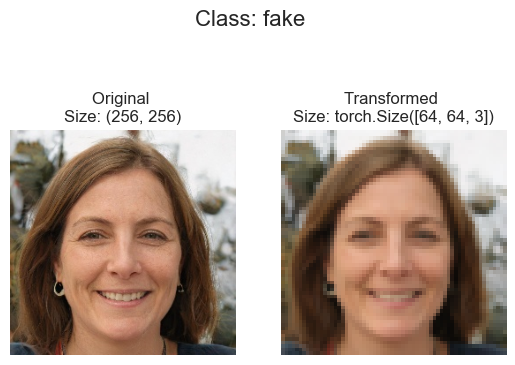

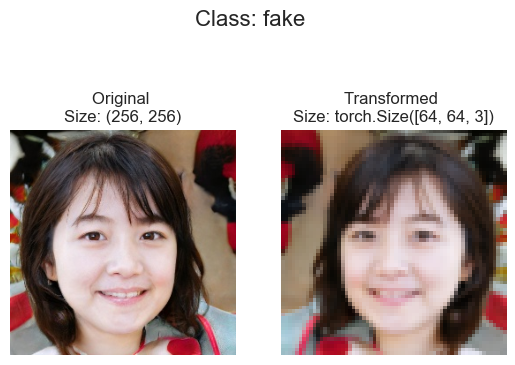

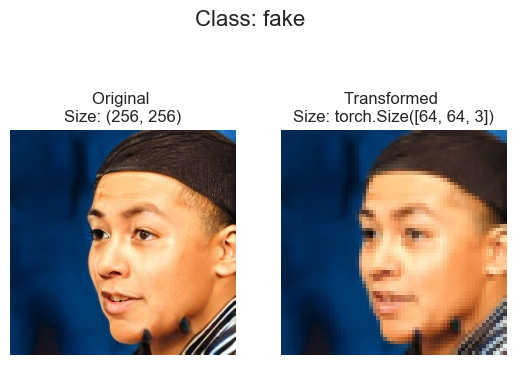

In [39]:
import random
from PIL import Image
from pathlib import Path


random.seed(42)

data_path = Path("RealvsFake_Face/")
image_path = data_path / "rvf10k"
train_dir = image_path / "train"
test_dir = image_path / "valid"
image_path_list = list(image_path.glob("*/*/*.jpg"))

def plot_transformed_images(image_paths, transform, n=5, seed=11):
    seed = random.randint(1,100)
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [40]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [41]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [42]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix,classification_report

# def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# def test_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     all_labels = []
#     all_predictions = []
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(test_loader):
#             inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             all_labels.extend(labels.cpu().numpy())
#             all_predictions.extend(predicted.cpu().numpy())
                
#     print('\nAccuracy on the test set: %d %%' % (100 * correct / total))
#     report = classification_report(all_labels, all_predictions, digits=4)
#     print("Classification Report:")
#     print(report)

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    losses = []  # List to store loss values for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    
    # Plotting using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs + 1), y=losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()



def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    print('\nAccuracy on the test set: %d %%' % accuracy)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Compute classification report
    report = classification_report(all_labels, all_predictions, digits=4)
    print("Classification Report:")
    print(report)


def test_model2(model, test_loader, num_examples=5):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, digits=4)
    
    # Plotting accuracy
    plt.figure(figsize=(8, 6))
    plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
    plt.title('Accuracy on the test set')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.show()
    
    print('Accuracy on the test set: %.2f %%' % accuracy)
    print("Classification Report:")
    print(report)
    
    # Example predictions
    print("\nExample Predictions:")
    for i in range(num_examples):
        example_input, example_label = next(iter(test_loader))
        example_input = example_input[0].unsqueeze(0).to(torch.device('cuda'))
        example_output = model(example_input)
        _, example_prediction = torch.max(example_output.data, 1)
        
        # Display example input as an image
        plt.figure()
        plt.imshow(example_input.cpu().numpy().squeeze().transpose(1, 2, 0))  # Assuming input is in NCHW format
        plt.title("Example Input")
        plt.axis('off')
        plt.show()
        
        t = example_prediction.item()
        if t==1:
            t = "Real"
        else:
            t = "Fake"
        print("Predicted Label:", t)
        print()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [43]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.c1 = nn.Conv2d(3,6,kernel_size=3)
        self.c2 = nn.Conv2d(6,16,kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
    def forward(self,x):
        x = self.pool(self.relu(self.c1(x)))
        x = self.pool(self.relu(self.c2(x)))
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/15, Loss: 0.6905743262984536
Epoch 2/15, Loss: 0.6742093080824072
Epoch 3/15, Loss: 0.6447658869353208
Epoch 4/15, Loss: 0.6246633123267781
Epoch 5/15, Loss: 0.60688660253178
Epoch 6/15, Loss: 0.5917108939452604
Epoch 7/15, Loss: 0.5817363820292732
Epoch 8/15, Loss: 0.5740705273368142
Epoch 9/15, Loss: 0.5687871786681089
Epoch 10/15, Loss: 0.5618931233882904
Epoch 11/15, Loss: 0.5594890179959211
Epoch 12/15, Loss: 0.556519376147877
Epoch 13/15, Loss: 0.5464892782948234
Epoch 14/15, Loss: 0.5511945204301314
Epoch 15/15, Loss: 0.5395570863376964


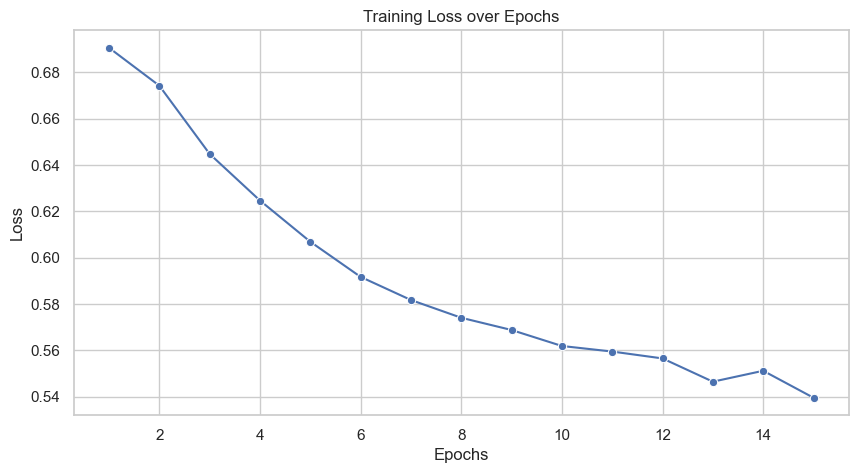


Accuracy on the test set: 72 %


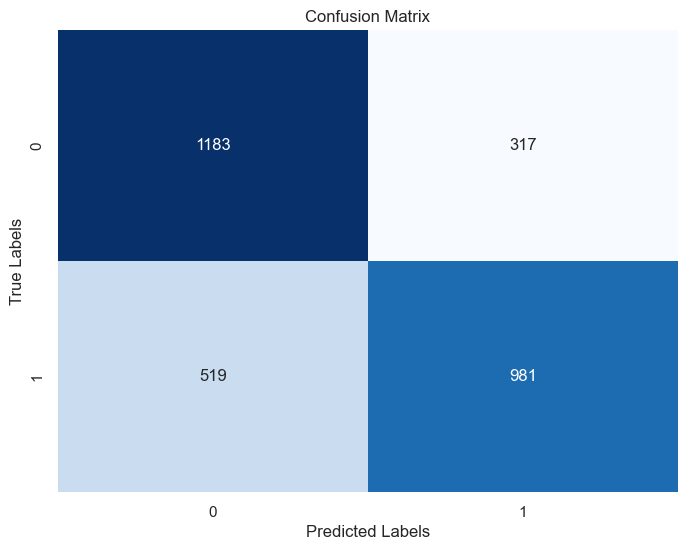

Classification Report:
              precision    recall  f1-score   support

           0     0.6951    0.7887    0.7389      1500
           1     0.7558    0.6540    0.7012      1500

    accuracy                         0.7213      3000
   macro avg     0.7254    0.7213    0.7201      3000
weighted avg     0.7254    0.7213    0.7201      3000



In [44]:
model1 = LeNet()
model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model1,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model1,test_dataloader)

In [45]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.c1 = nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2)
        self.c2 = nn.Conv2d(64,192,kernel_size=5,padding=2)
        self.c3 = nn.Conv2d(192,384,kernel_size=3,padding=1)
        self.c4 = nn.Conv2d(384,256,kernel_size=3,padding=1)
        self.c5 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout()
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    def forward(self,x):
        x = self.pool(self.relu((self.c1(x))))
        x = self.pool(self.relu((self.c2(x))))
        x = self.relu((self.c3(x)))
        x = self.relu((self.c4(x)))
        x = self.relu((self.c5(x)))
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.relu(self.fc1(self.drop(x)))
        x = self.relu(self.fc2(self.drop(x)))
        x = self.fc3(x)
        return x

Epoch 1/15, Loss: 0.693459611047398
Epoch 2/15, Loss: 0.6261655956506729
Epoch 3/15, Loss: 0.5489589038220319
Epoch 4/15, Loss: 0.5090606556697326
Epoch 5/15, Loss: 0.4648402601480484
Epoch 6/15, Loss: 0.43782136711207303
Epoch 7/15, Loss: 0.40800280543890866
Epoch 8/15, Loss: 0.37193166545846246
Epoch 9/15, Loss: 0.34484602876684883
Epoch 10/15, Loss: 0.3154301808639006
Epoch 11/15, Loss: 0.2881960993463343
Epoch 12/15, Loss: 0.2618176215751605
Epoch 13/15, Loss: 0.2282214143736796
Epoch 14/15, Loss: 0.2055230514569716
Epoch 15/15, Loss: 0.16227520971812986


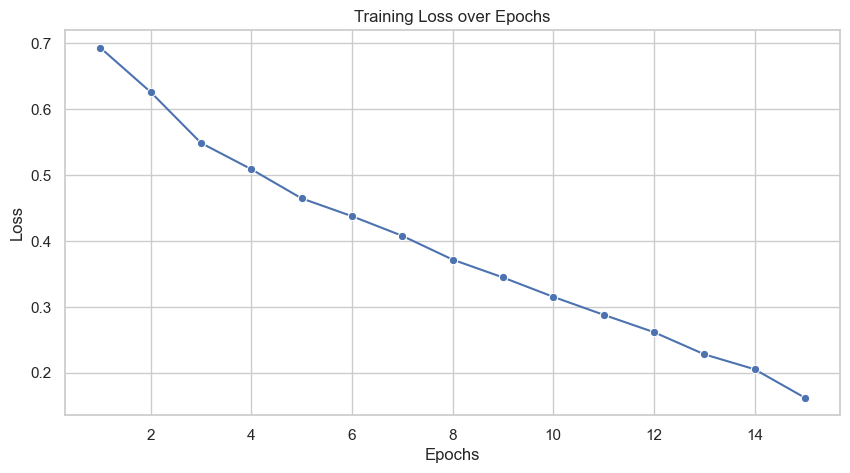


Accuracy on the test set: 76 %


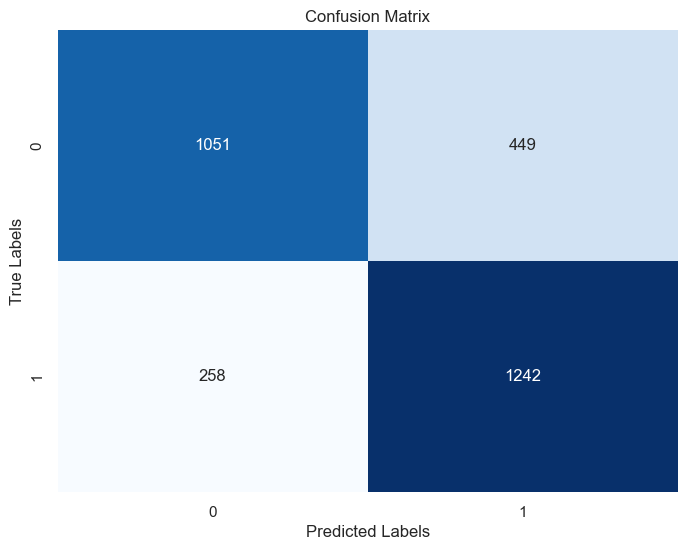

Classification Report:
              precision    recall  f1-score   support

           0     0.8029    0.7007    0.7483      1500
           1     0.7345    0.8280    0.7784      1500

    accuracy                         0.7643      3000
   macro avg     0.7687    0.7643    0.7634      3000
weighted avg     0.7687    0.7643    0.7634      3000



In [46]:
model2 = AlexNet()
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model2,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model2,test_dataloader)

In [47]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, conv1x1, conv3x3_reduce, conv3x3, conv5x5_reduce, conv5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = BasicConv2d(in_channels, conv1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, conv3x3_reduce, kernel_size=1),
            BasicConv2d(conv3x3_reduce, conv3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, conv5x5_reduce, kernel_size=1),
            BasicConv2d(conv5x5_reduce, conv5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

class InceptionV1(nn.Module):
    def __init__(self):
        super(InceptionV1, self).__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


Epoch 1/15, Loss: 0.7001172103665092
Epoch 2/15, Loss: 0.6472339359196749
Epoch 3/15, Loss: 0.5879515276713805
Epoch 4/15, Loss: 0.5356454448266463
Epoch 5/15, Loss: 0.4802533583207564
Epoch 6/15, Loss: 0.4215702167966149
Epoch 7/15, Loss: 0.36558415551077234
Epoch 8/15, Loss: 0.32447374557906933
Epoch 9/15, Loss: 0.27726375419985166
Epoch 10/15, Loss: 0.23676226355812766
Epoch 11/15, Loss: 0.21404291506518017
Epoch 12/15, Loss: 0.20224025547504426
Epoch 13/15, Loss: 0.15672053901309316
Epoch 14/15, Loss: 0.15096956396644765
Epoch 15/15, Loss: 0.13223899457265031


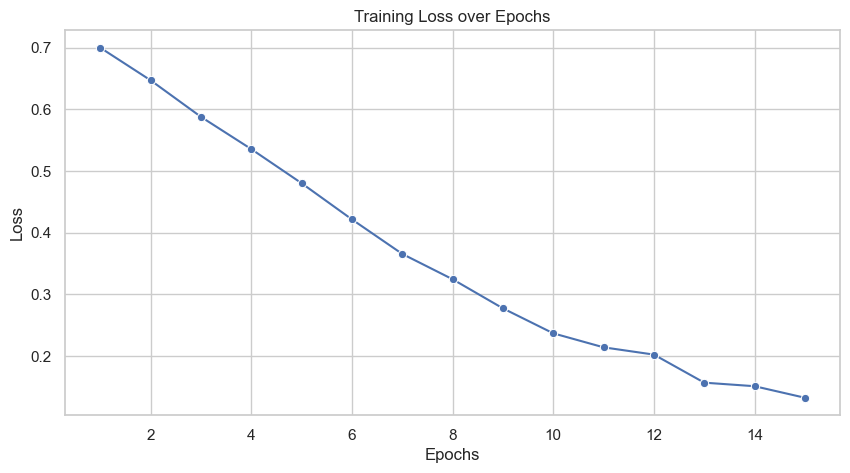


Accuracy on the test set: 75 %


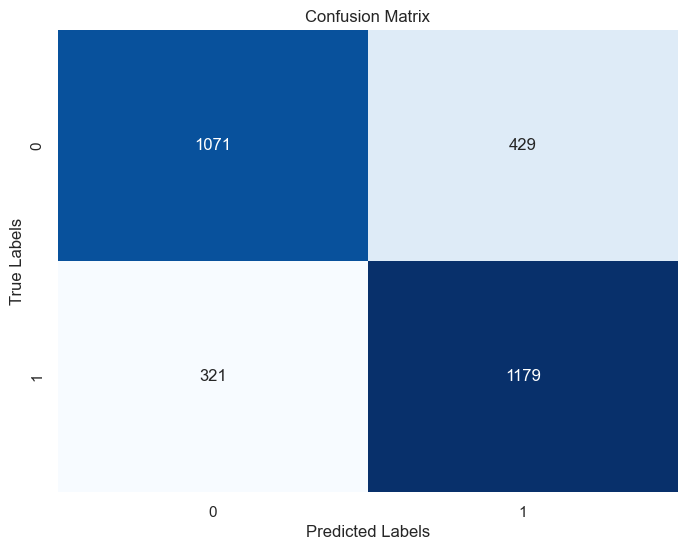

Classification Report:
              precision    recall  f1-score   support

           0     0.7694    0.7140    0.7407      1500
           1     0.7332    0.7860    0.7587      1500

    accuracy                         0.7500      3000
   macro avg     0.7513    0.7500    0.7497      3000
weighted avg     0.7513    0.7500    0.7497      3000



In [48]:
model3 = InceptionV1()
model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model3,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model3,test_dataloader)

In [49]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


Epoch 1/15, Loss: 0.6933354128490795
Epoch 2/15, Loss: 0.6934140395034444
Epoch 3/15, Loss: 0.6933630986647172
Epoch 4/15, Loss: 0.6932665873657573
Epoch 5/15, Loss: 0.6932873769239946
Epoch 6/15, Loss: 0.6934027297930284
Epoch 7/15, Loss: 0.6932459733702919
Epoch 8/15, Loss: 0.6932841311801564
Epoch 9/15, Loss: 0.6933698854663155
Epoch 10/15, Loss: 0.6933489284732125
Epoch 11/15, Loss: 0.6933506082404743
Epoch 12/15, Loss: 0.6932860612869263
Epoch 13/15, Loss: 0.6933412643996152
Epoch 14/15, Loss: 0.6934757443991575
Epoch 15/15, Loss: 0.6932038220492276


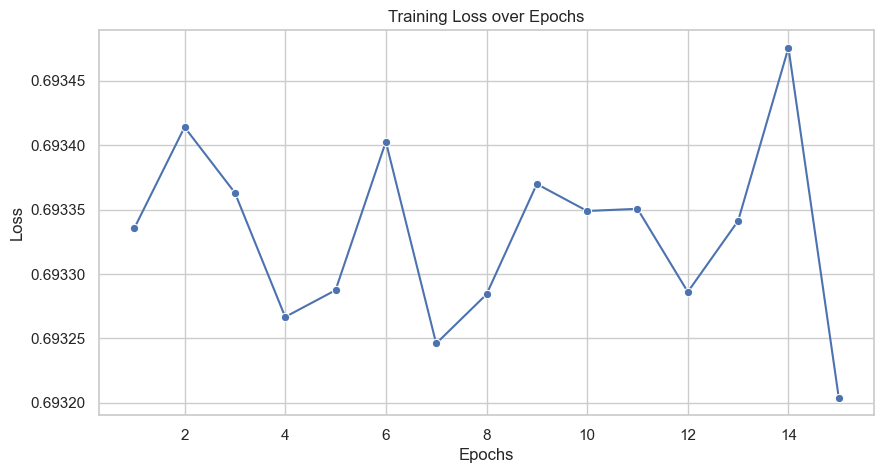


Accuracy on the test set: 50 %


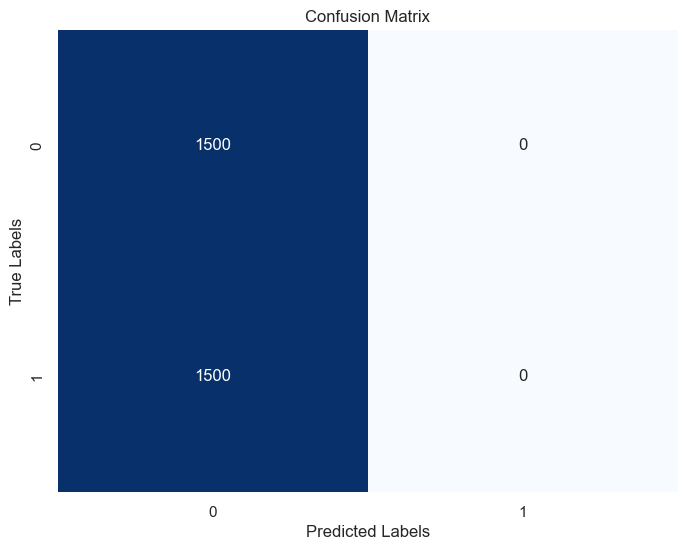

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667      1500
           1     0.0000    0.0000    0.0000      1500

    accuracy                         0.5000      3000
   macro avg     0.2500    0.5000    0.3333      3000
weighted avg     0.2500    0.5000    0.3333      3000



c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [50]:
model4 = VGG16()
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model4,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model4,test_dataloader)

In [51]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = nn.ReLU()(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, 2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

# Define ResNet-50 model
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


Epoch 1/15, Loss: 0.7091487917033109
Epoch 2/15, Loss: 0.6581125825643539
Epoch 3/15, Loss: 0.6168710248036818
Epoch 4/15, Loss: 0.5597077125852759
Epoch 5/15, Loss: 0.5186114598404278
Epoch 6/15, Loss: 0.455055846138434
Epoch 7/15, Loss: 0.3846813948317008
Epoch 8/15, Loss: 0.3415092621337284
Epoch 9/15, Loss: 0.30891866927797146
Epoch 10/15, Loss: 0.28312200104648416
Epoch 11/15, Loss: 0.23054961013523015
Epoch 12/15, Loss: 0.23049008087678388
Epoch 13/15, Loss: 0.20823225907304072
Epoch 14/15, Loss: 0.18304386978799647
Epoch 15/15, Loss: 0.16283673423935066


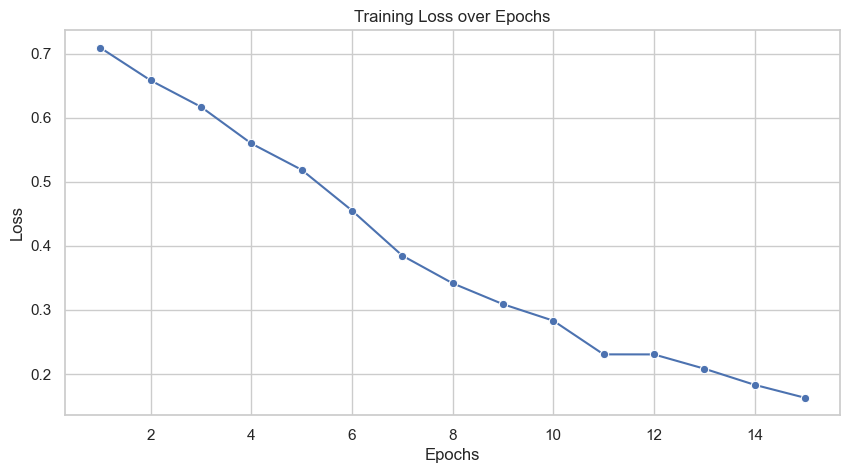


Accuracy on the test set: 74 %


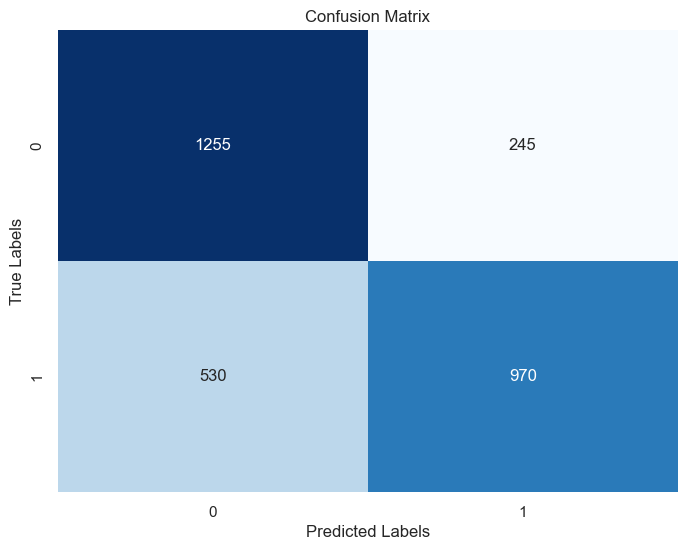

Classification Report:
              precision    recall  f1-score   support

           0     0.7031    0.8367    0.7641      1500
           1     0.7984    0.6467    0.7145      1500

    accuracy                         0.7417      3000
   macro avg     0.7507    0.7417    0.7393      3000
weighted avg     0.7507    0.7417    0.7393      3000



In [52]:
model5 = ResNet50()
model5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model5,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model5,test_dataloader)

In [53]:
class AlexNetv2(nn.Module):
    def __init__(self):
        super(AlexNetv2,self).__init__()
        self.c1 = nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2)
        self.b1 = nn.BatchNorm2d(64)
        self.c2 = nn.Conv2d(64,192,kernel_size=5,padding=2)
        self.b2 = nn.BatchNorm2d(192)
        self.c3 = nn.Conv2d(192,384,kernel_size=3,padding=1)
        self.b3 = nn.BatchNorm2d(384)
        self.c4 = nn.Conv2d(384,256,kernel_size=3,padding=1)
        self.b4 = nn.BatchNorm2d(256)
        self.c5 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.b5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout()
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    def forward(self,x):
        x = self.pool(self.relu(self.b1(self.c1(x))))
        x = self.pool(self.relu(self.b2(self.c2(x))))
        x = self.relu(self.b3(self.c3(x)))
        x = self.relu(self.b4(self.c4(x)))
        x = self.relu(self.b5(self.c5(x)))
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.relu(self.fc1(self.drop(x)))
        x = self.relu(self.fc2(self.drop(x)))
        x = self.fc3(x)
        return x

Epoch 1/15, Loss: 0.7422115287997506
Epoch 2/15, Loss: 0.5783308576453816
Epoch 3/15, Loss: 0.513622230833227
Epoch 4/15, Loss: 0.47024095491929485
Epoch 5/15, Loss: 0.4350752546028657
Epoch 6/15, Loss: 0.3904406249523163
Epoch 7/15, Loss: 0.35649319643324073
Epoch 8/15, Loss: 0.3320795182477344
Epoch 9/15, Loss: 0.2939870311455293
Epoch 10/15, Loss: 0.26045320738445626
Epoch 11/15, Loss: 0.24628690921447494
Epoch 12/15, Loss: 0.204826691408049
Epoch 13/15, Loss: 0.19305543527007102
Epoch 14/15, Loss: 0.17802501913498747
Epoch 15/15, Loss: 0.16384855739094994


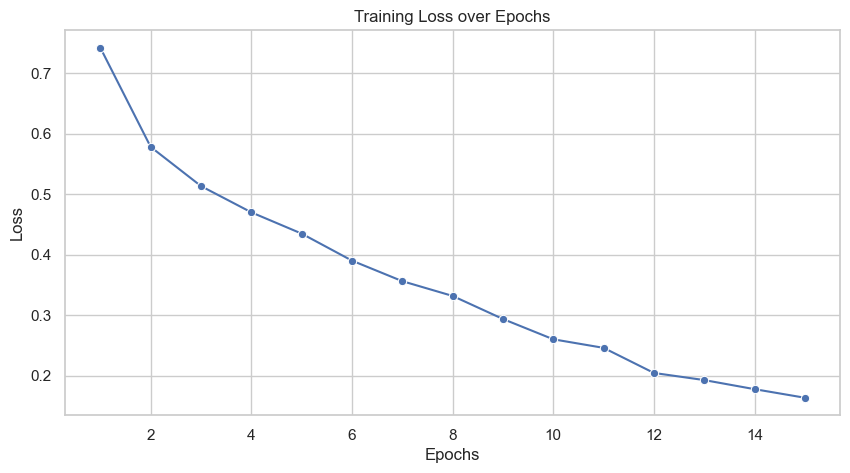


Accuracy on the test set: 64 %


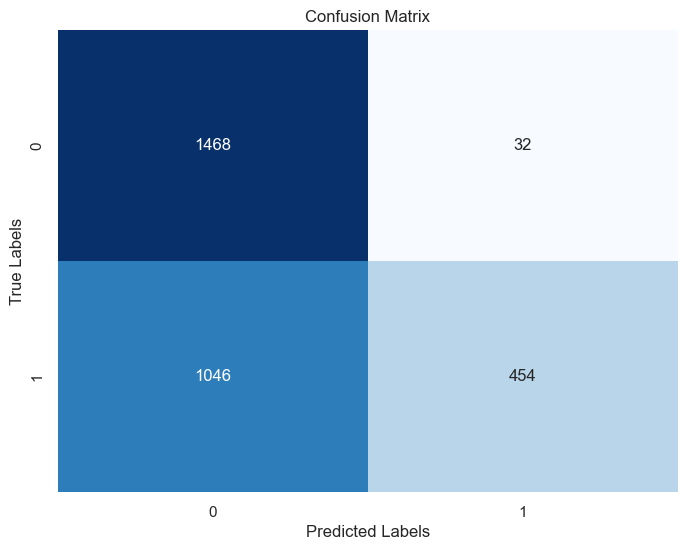

Classification Report:
              precision    recall  f1-score   support

           0     0.5839    0.9787    0.7314      1500
           1     0.9342    0.3027    0.4572      1500

    accuracy                         0.6407      3000
   macro avg     0.7590    0.6407    0.5943      3000
weighted avg     0.7590    0.6407    0.5943      3000



In [54]:
model6 = AlexNetv2()
model6.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=0.0001)

torch.cuda.empty_cache()
train_model(model6,train_dataloader, criterion, optimizer, num_epochs=15)
torch.cuda.empty_cache()
test_model(model6,test_dataloader)

LeNet


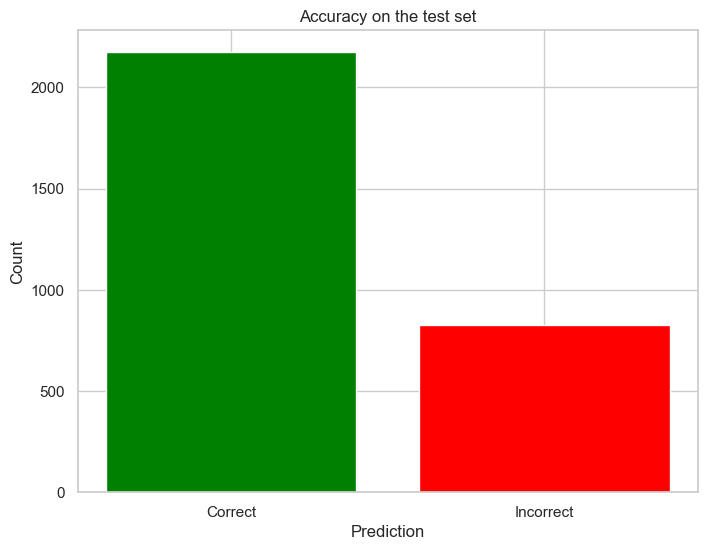

Accuracy on the test set: 72.47 %
Classification Report:
              precision    recall  f1-score   support

           0     0.6985    0.7907    0.7417      1500
           1     0.7588    0.6587    0.7052      1500

    accuracy                         0.7247      3000
   macro avg     0.7287    0.7247    0.7235      3000
weighted avg     0.7287    0.7247    0.7235      3000


Example Predictions:


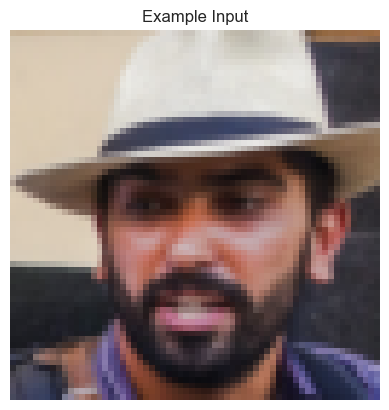

Predicted Label: Real



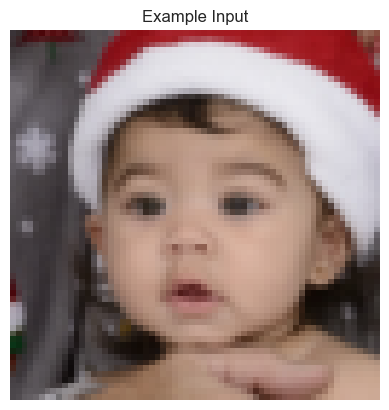

Predicted Label: Real



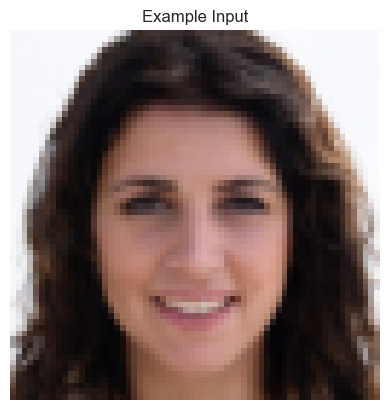

Predicted Label: Fake



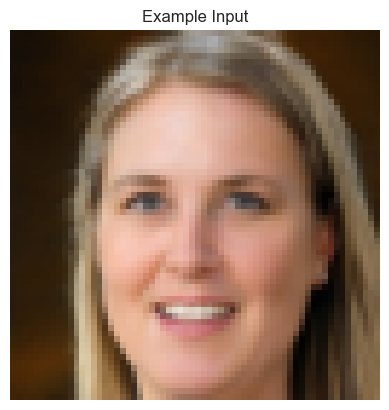

Predicted Label: Fake



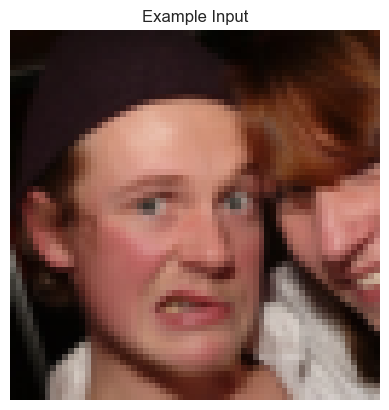

Predicted Label: Fake

AlexNet


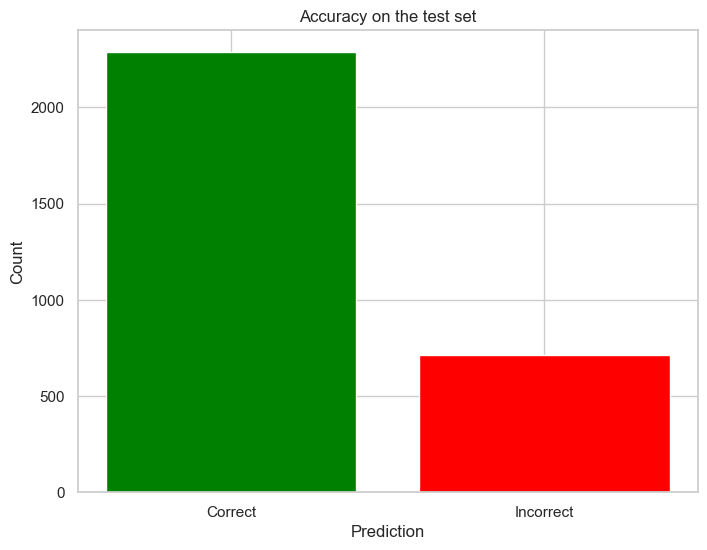

Accuracy on the test set: 76.23 %
Classification Report:
              precision    recall  f1-score   support

           0     0.8025    0.6960    0.7454      1500
           1     0.7316    0.8287    0.7771      1500

    accuracy                         0.7623      3000
   macro avg     0.7670    0.7623    0.7613      3000
weighted avg     0.7670    0.7623    0.7613      3000


Example Predictions:


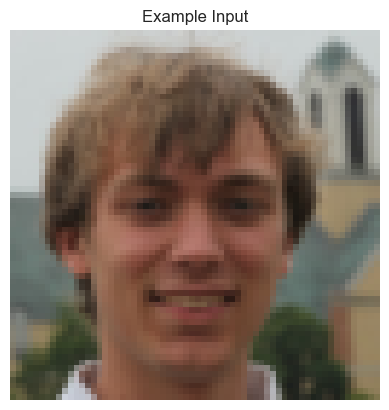

Predicted Label: Fake



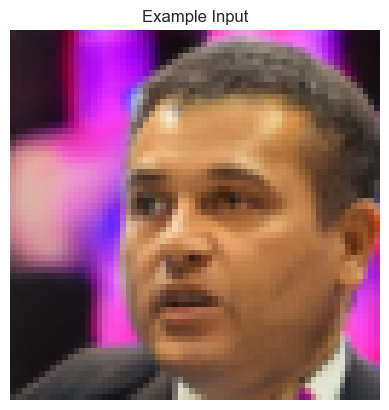

Predicted Label: Real



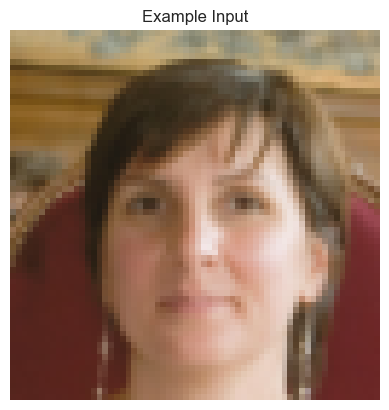

Predicted Label: Real



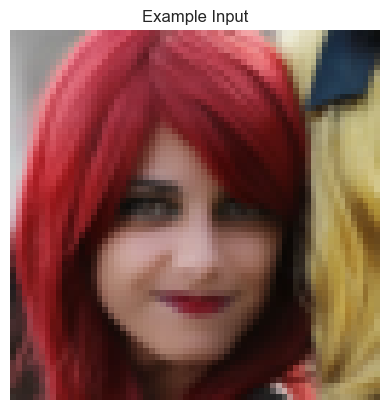

Predicted Label: Real



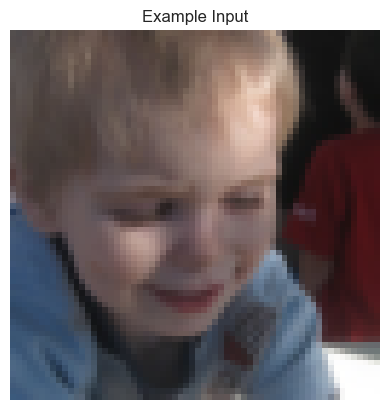

Predicted Label: Real

InceptionV1


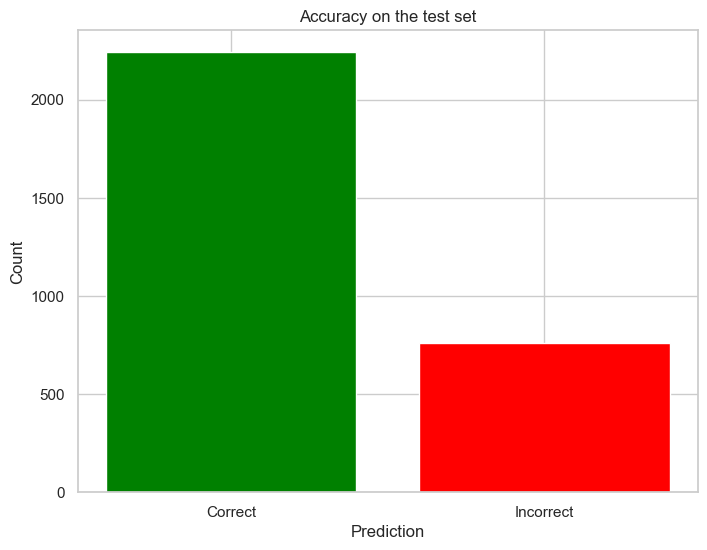

Accuracy on the test set: 74.73 %
Classification Report:
              precision    recall  f1-score   support

           0     0.7646    0.7147    0.7388      1500
           1     0.7322    0.7800    0.7553      1500

    accuracy                         0.7473      3000
   macro avg     0.7484    0.7473    0.7471      3000
weighted avg     0.7484    0.7473    0.7471      3000


Example Predictions:


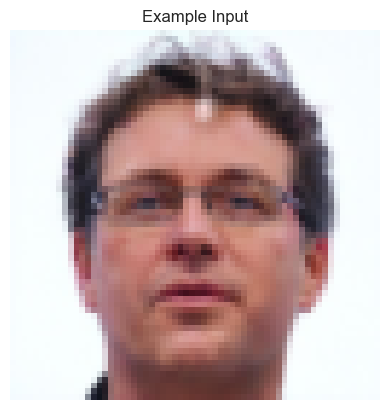

Predicted Label: Fake



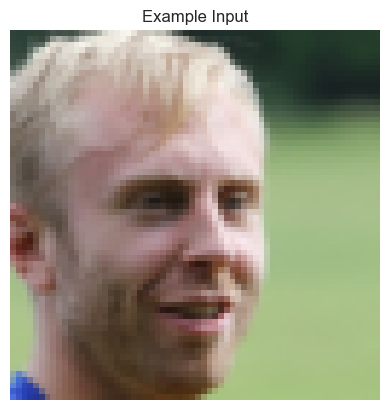

Predicted Label: Real



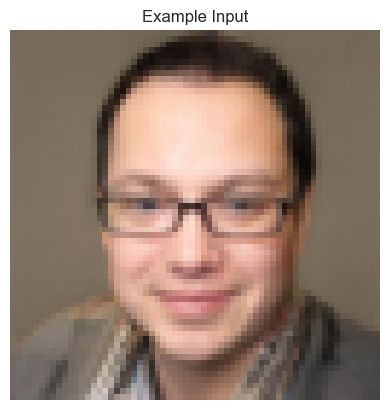

Predicted Label: Fake



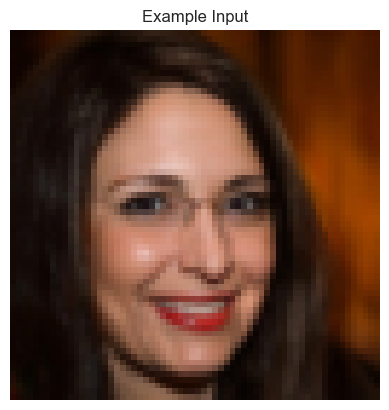

Predicted Label: Real



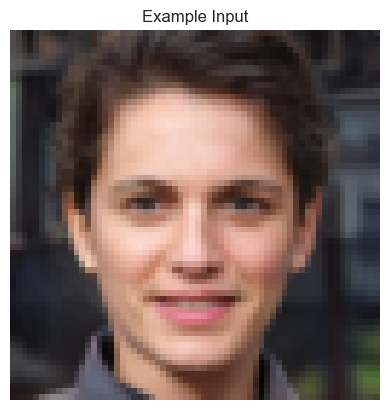

Predicted Label: Fake

VGG16


c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

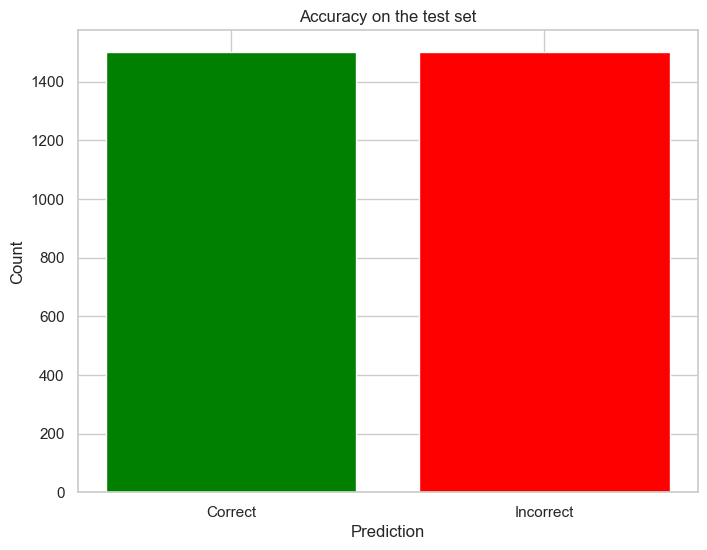

Accuracy on the test set: 50.00 %
Classification Report:
              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667      1500
           1     0.0000    0.0000    0.0000      1500

    accuracy                         0.5000      3000
   macro avg     0.2500    0.5000    0.3333      3000
weighted avg     0.2500    0.5000    0.3333      3000


Example Predictions:


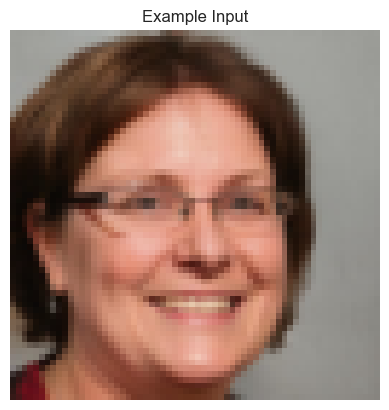

Predicted Label: Fake



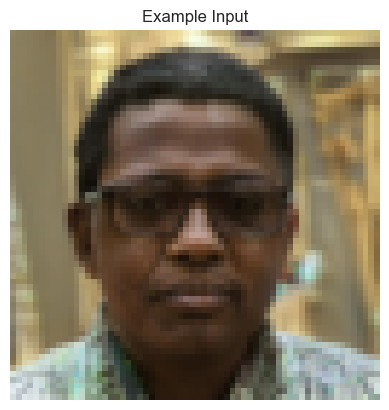

Predicted Label: Fake



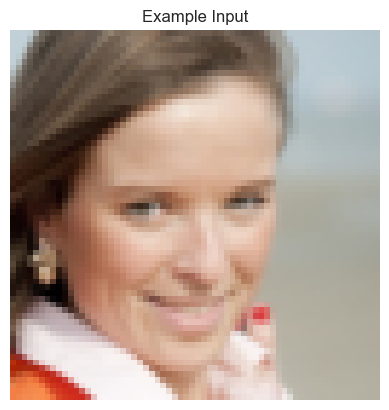

Predicted Label: Fake



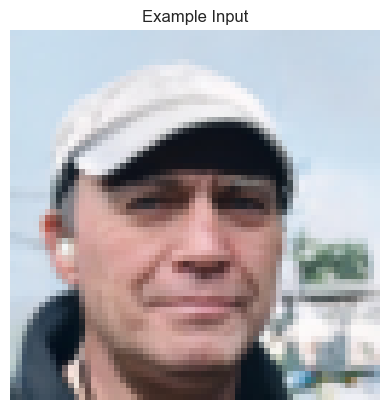

Predicted Label: Fake



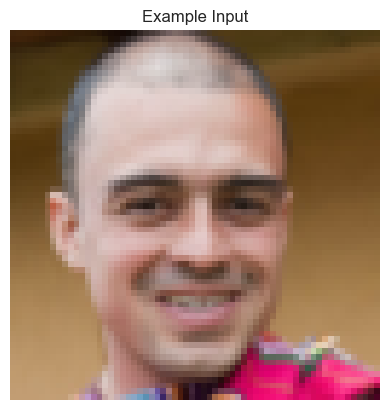

Predicted Label: Fake

ResNet


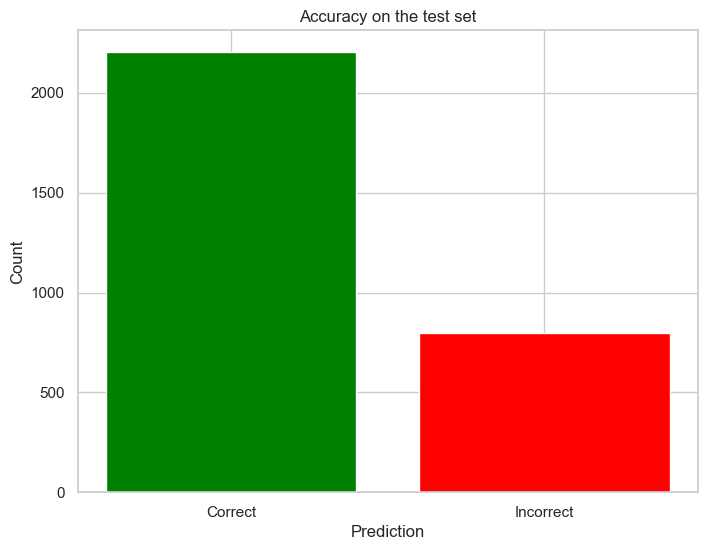

Accuracy on the test set: 73.43 %
Classification Report:
              precision    recall  f1-score   support

           0     0.6976    0.8273    0.7569      1500
           1     0.7879    0.6413    0.7071      1500

    accuracy                         0.7343      3000
   macro avg     0.7427    0.7343    0.7320      3000
weighted avg     0.7427    0.7343    0.7320      3000


Example Predictions:


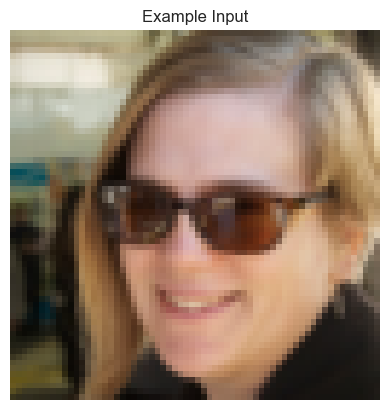

Predicted Label: Real



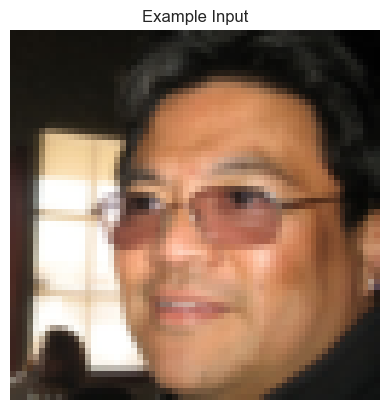

Predicted Label: Real



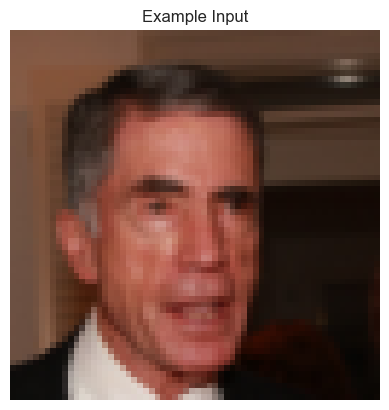

Predicted Label: Real



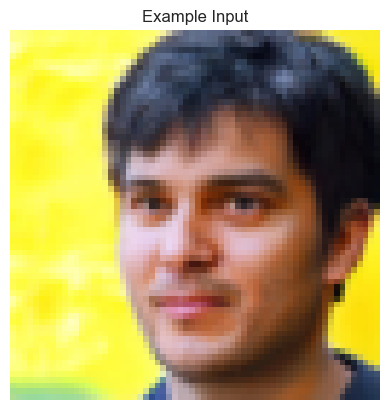

Predicted Label: Real



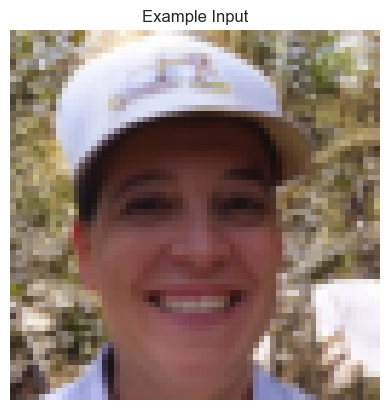

Predicted Label: Fake

AlexNetv2


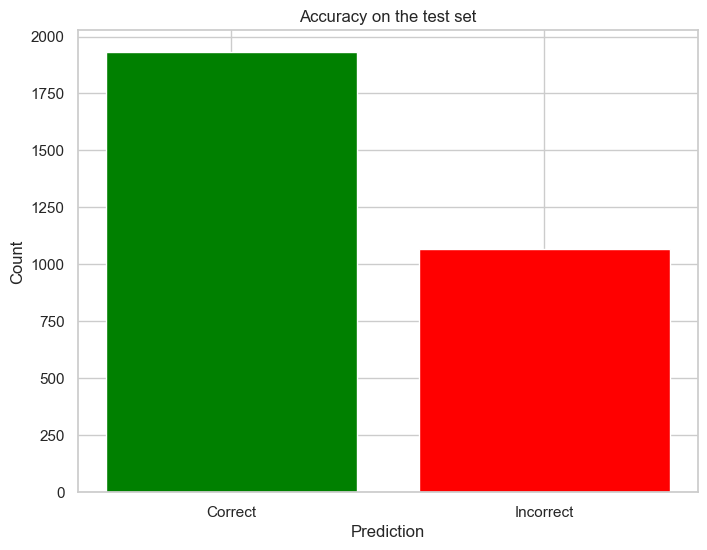

Accuracy on the test set: 64.37 %
Classification Report:
              precision    recall  f1-score   support

           0     0.5858    0.9813    0.7336      1500
           1     0.9425    0.3060    0.4620      1500

    accuracy                         0.6437      3000
   macro avg     0.7641    0.6437    0.5978      3000
weighted avg     0.7641    0.6437    0.5978      3000


Example Predictions:


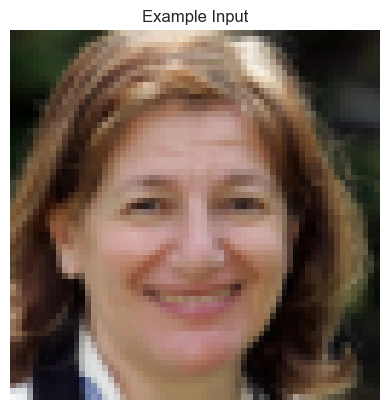

Predicted Label: Fake



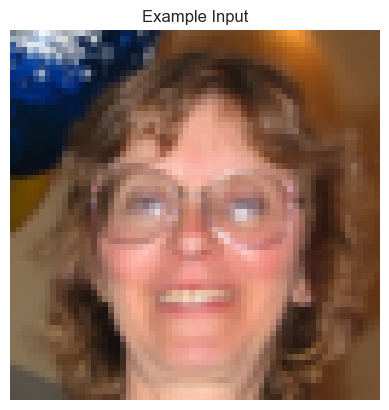

Predicted Label: Fake



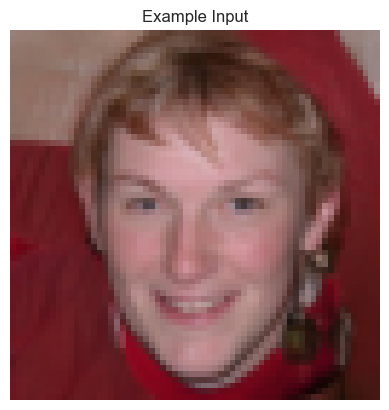

Predicted Label: Fake



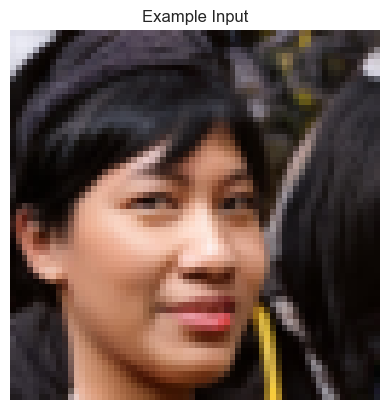

Predicted Label: Fake



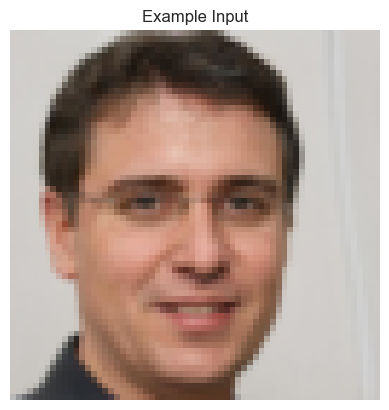

Predicted Label: Fake



In [55]:
print("LeNet")
test_model2(model1, test_dataloader)
print("AlexNet")
test_model2(model2, test_dataloader)
print("InceptionV1")
test_model2(model3, test_dataloader)
print("VGG16")
test_model2(model4, test_dataloader)
print("ResNet")
test_model2(model5, test_dataloader)
print("AlexNetv2")
test_model2(model6, test_dataloader)